In [1]:
# eeg.txt…脳波データ（前半：閉眼時，後半：開眼時，2ch，200SPS）

import matplotlib.pyplot as plt

# 日本語フォント設定
from matplotlib import rc
jp_font = "Yu Gothic"
rc('font', family=jp_font)

import numpy as np
from scipy import signal

from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq

In [2]:
Fs = 200             # サンプリング周波数
                     # 0.005sec = 5msec

EGG_FILE_NAME = "eeg.txt"   # 脳波データファイル

DAT_LEN = 100        # データ長[s]

CH = 1               # 対象チャネル（0：ch1、1:ch2）

# 電圧変換係数 5V / 12bitADC / Gain=1000 [us]
AMP_COEF = 5.0/2**12/1000*1000000
                     # 5V / 12bitADC / Gain=1000[us]

In [3]:
def read_dat(filename):
    dat = np.loadtxt(filename, delimiter="\t")
    dat = dat[0:int(Fs * DAT_LEN), CH]*AMP_COEF
    return dat

In [4]:
Fh = 0.5             # ハイパス フィルタ遮断周波数
Fl = 30.0            # ローパス フィルタ遮断周波数
Nf = 1               # ハイパスフィルタ／ローパスフィルタの次数

Fn = 50.0            # ノッチフィルタ中心周波数
Q  = 4.0             # ノッチフィルタのQ値

# バターワース型フィルタの係数算出
# 21ページ目
bh, ah = signal.butter(Nf, Fh, "high", fs=Fs)
bl, al = signal.butter(Nf, Fl, "low", fs=Fs)

# ノッチフィルタの設計
bn, an = signal.iirnotch(Fn, Q, fs=Fs)

In [5]:
dat = read_dat(EGG_FILE_NAME)


# ハイパスフィルタ適用
dat1 = signal.lfilter(bh, ah, dat)


# ローパスフィルタ適用
dat2 = signal.lfilter(bl, al, dat1)

# ノッチフィルタ適用
dat3 = signal.lfilter(bn, an, dat2)

In [6]:
def spectrum(dat, window="boxcar"):
    LEN = len(dat)
    win = signal.get_window(window, LEN)
    enbw = LEN * np.sum(win**2) / np.sum(win)**2
    
    # 両側スペクトル (参考（未使用）)
    fft_dat = fftshift(fft(dat * win))
    fft_freq = fftshift(fftfreq(LEN, d=1.0 / Fs))
    sp_dat = np.abs(fft_dat)**2 / (LEN * Fs * enbw)
    sp_dat[1:-1] *= 2  # 2倍（DCとナイキスト周波数除く）
    
    # 片側スペクトル
    rfft_dat = rfft(dat * win)
    rfft_freq = rfftfreq(LEN, d=1.0 / Fs)
    sp_rdat = np.abs(rfft_dat)**2 / (LEN * Fs * enbw)
    sp_rdat[1:-1] *= 2  # 2倍（DCとナイキスト周波数除く）
    
    return rfft_freq, sp_rdat

In [11]:
def plot_spectrogrma(dat, title=""):
    f, t, Sxx = signal.spectrogram(dat, Fs, window="boxcar", nperseg=Fs*2, noverlap=Fs, mode="psd")
    plt.figure(figsize=[13, 4])
    plt.pcolormesh(t, f, Sxx, cmap="jet", vmax=100, shading="auto")  # shadingを指定しないと警告が出てくる
    plt.ylim([0, Fs/2])
    plt.xlabel("Time [s]")
    plt.ylabel("Freq [Hz]")
    plt.colorbar().set_label("PSD [uV^2/Hz]")
    plt.title(title)
    
    plt.show()

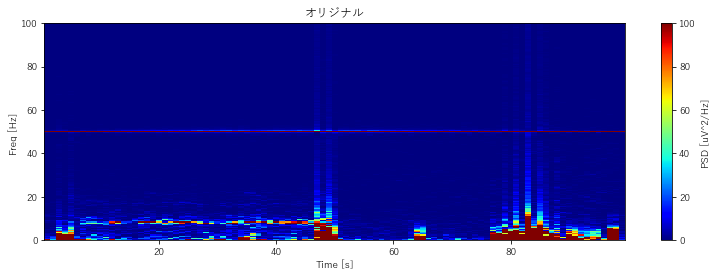

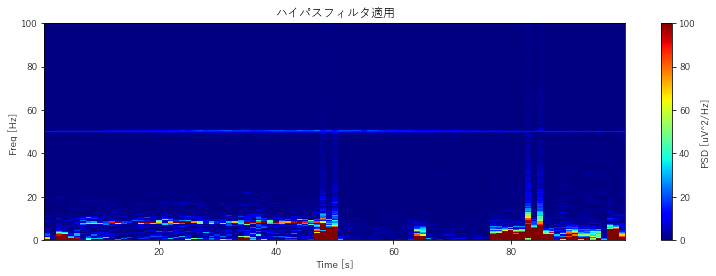

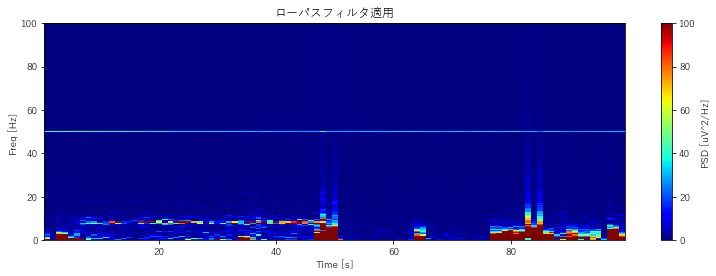

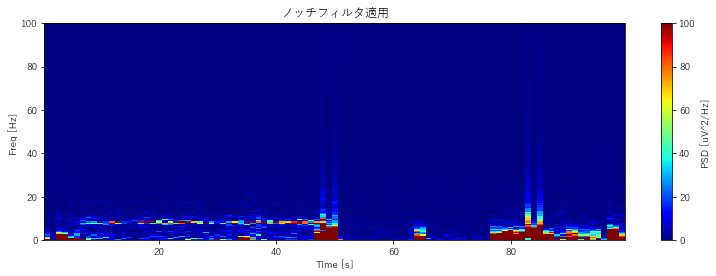

In [12]:
plot_spectrogrma(dat,  "オリジナル")

# ハイパスフィルタで低い周波数をカットして、高い周波数を通す
plot_spectrogrma(dat1, "ハイパスフィルタ適用")

# ローパスフィルタで低い周波数を通して、高い周波数をカットする
plot_spectrogrma(dat2, "ローパスフィルタ適用")

# ノッチフィルタは特定の範囲のみカットするフィルタ
plot_spectrogrma(dat3, "ノッチフィルタ適用")

In [17]:
YLIM = 310           # 波形のYレンジ（+/-）

def plot_wave(dat, dat1, title):
    t = np.arange(len(dat))/Fs
    
    plt.figure(figsize=[15,5])
    
    plt.subplot(131)
    plt.plot(t, dat)
    plt.ylim(-YLIM, YLIM)
    plt.xlabel("Time [s]")
    plt.ylabel("Ch"+str(CH+1)+"[uV]")
    plt.title(title)

    plt.subplot(132)
    plt.plot(dat1[0], dat1[1])
    # plt.ylim(0, 1000)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [uV^2/Hz]')  # PSD (Power spectral density)
    
    plt.subplot(133)
    f, t, Sxx = signal.spectrogram(dat, Fs, window="boxcar", nperseg=Fs*2, noverlap=Fs, mode="psd")
    plt.pcolormesh(t, f, Sxx, cmap="jet", vmax=100, shading="auto")  # shadingを指定しないと警告が出てくる
    plt.ylim([0, Fs/2])
    plt.xlabel("Time [s]")
    plt.ylabel("Freq [Hz]")
    plt.colorbar().set_label("PSD [uV^2/Hz]")
       
    
    plt.show()

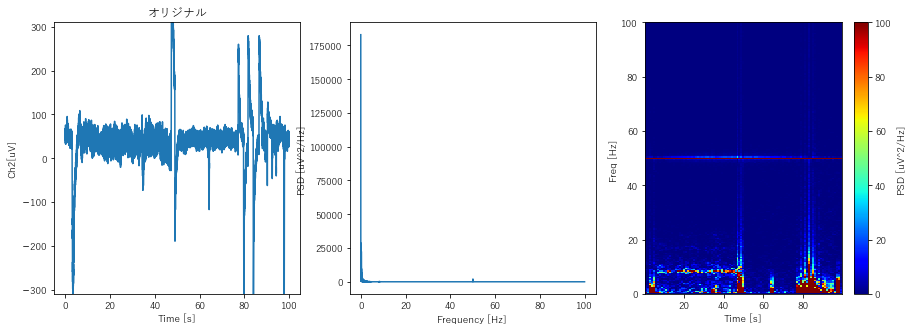

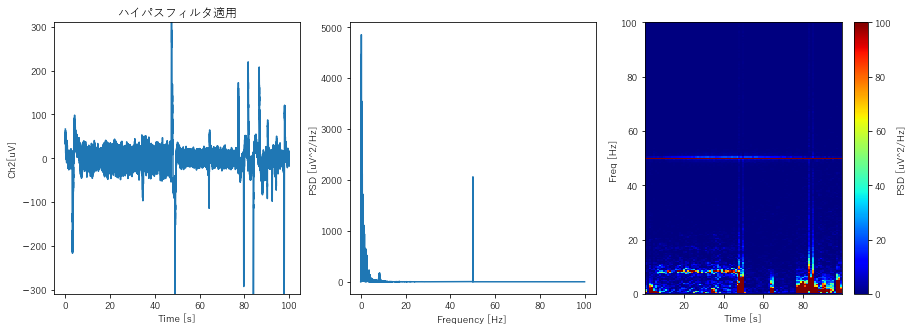

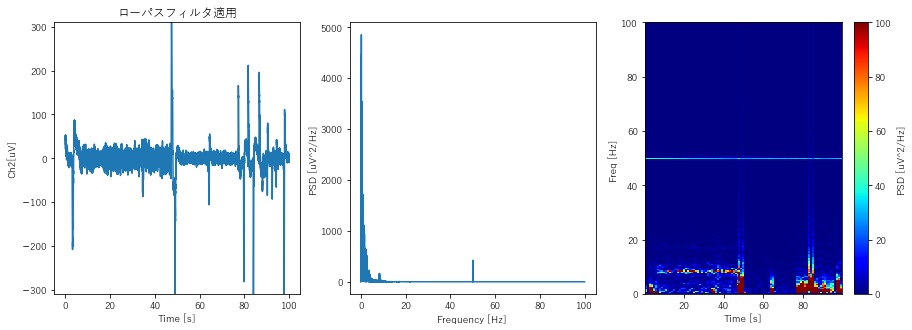

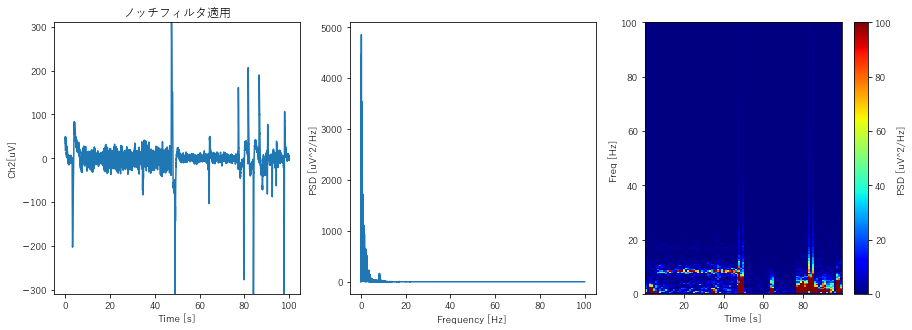

In [18]:
plot_wave(dat, spectrum(dat),  "オリジナル")

# ハイパスフィルタで低い周波数をカットして、高い周波数を通す
plot_wave(dat1, spectrum(dat1), "ハイパスフィルタ適用")

# ローパスフィルタで低い周波数を通して、高い周波数をカットする
plot_wave(dat2, spectrum(dat2), "ローパスフィルタ適用")

# ノッチフィルタは特定の範囲のみカットするフィルタ
plot_wave(dat3, spectrum(dat3), "ノッチフィルタ適用")